#**Pré-processamento**

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

import pandas as pd
import seaborn as sns
import missingno as msno
import warnings
from matplotlib import pyplot as plt
import datetime
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)

df = pd.read_csv("gdrive/My Drive/dissertação/Qualidade_do_ar_-_Dados_horarios.csv",sep=",")
df['Data']=df['Data'].astype('str')
df['Data']=df['Data'].apply(lambda x: x[:-3])

#conversão para datetime
def convert_to_datetime(x):
    return(datetime.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))
df['Data']=df['Data'].apply(convert_to_datetime) 
df['Hora-minuto']=df['Data'].apply(lambda x: str(x)[-8:-3])
# #extrair ano, mes, hora 
df['Ano']=df['Data'].apply(lambda x: x.year)
df['Mês']=df['Data'].apply(lambda x: x.month)
df['Dia']=df['Data'].apply(lambda x: x.day)
df['Hora']=df['Data'].apply(lambda x: x.hour)
df['Hora-minuto']=df['Data'].apply(lambda x: str(x)[-11:-6])

df_bg=df[df['Estação']=='BG'] #Bangu
df_gc=df[df['Estação']=='CG'] #Campo Grande
df_ca=df[df['Estação']=='CA'] #Centro
df_av=df[df['Estação']=='AV'] #Copacabana
df_ir=df[df['Estação']=='IR'] #Irajá
df_pg=df[df['Estação']=='PG'] #Pedra de Guaratiba
df_sc=df[df['Estação']=='SC'] #São Cristóvão
df_sp=df[df['Estação']=='SP'] #Tijuca

df_sc.set_index('Data',inplace=True)
df_sc.drop(columns=['OBJECTID','CodNum','Estação','Dir_Vento','NO2','HCNM','HCT','CH4','NO','NOx',\
                   'PM2_5', 'Lat', 'Lon', 'X_UTM_Sirgas2000','Y_UTM_Sirgas2000'], inplace=True)
df_sc_2=df_sc.copy() #para fazer distribuição sem eliminar ausentes

df_sc=df_sc['2011-01-01':'2018-01-01']
#explicar que usou interpolação linear com spline e justificar
df_sc['Chuva'].interpolate(method='slinear', inplace=True)
df_sc['Pres'].interpolate(method='slinear', inplace=True)
df_sc['RS'].interpolate(method='slinear', inplace=True)
df_sc['Temp'].interpolate(method='slinear', inplace=True)
df_sc['UR'].interpolate(method='slinear', inplace=True)
df_sc['Vel_Vento'].interpolate(method='slinear', inplace=True)
df_sc['SO2'].interpolate(method='slinear', inplace=True)
df_sc['CO'].interpolate(method='slinear', inplace=True)
df_sc['O3'].interpolate(method='slinear', inplace=True)
df_sc['PM10'].interpolate(method='slinear', inplace=True)

Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
len(df_sc)

60361

#**LAG=2**


In [2]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 2
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 2190  * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
106/106 - 1s - loss: 0.0441 - val_loss: 0.0432
Epoch 2/150
106/106 - 0s - loss: 0.0382 - val_loss: 0.0298
Epoch 3/150
106/106 - 0s - loss: 0.0339 - val_loss: 0.0270
Epoch 4/150
106/106 - 0s - loss: 0.0310 - val_loss: 0.0256
Epoch 5/150
106/106 - 0s - loss: 0.0293 - val_loss: 0.0245
Epoch 6/150
106/106 - 0s - loss: 0.0278 - val_loss: 0.0236
Epoch 7/150
106/106 - 0s - loss: 0.0267 - val_loss: 0.0230
Epoch 8/150
106/106 - 0s - loss: 0.0260 - val_loss: 0.0225
Epoch 9/150
106/106 - 0s - loss: 0.0255 - val_loss: 0.0222
Epoch 10/150
106/106 - 0s - loss: 0.0250 - val_loss: 0.0221
Epoch 11/150
106/106 - 0s - loss: 0.0248 - val_loss: 0.0221
Epoch 12/150
106/106 - 0s - loss: 0.0246 - val_loss: 0.0220
Epoch 13/150
106/106 - 0s - loss: 0.0245 - val_loss: 0.0221
Epoch 14/150
106/106 - 0s - loss: 0.0244 - val_loss: 0.0220
Epoch 15/150
106/106 - 0s - loss: 0.0243 - val_loss: 0.0220
Epoch 16/150
106/106 - 0s - loss: 0.0242 - val_loss: 0.0220
Epoch 17/150
106/106 - 0s - loss: 0.0242 - val_lo

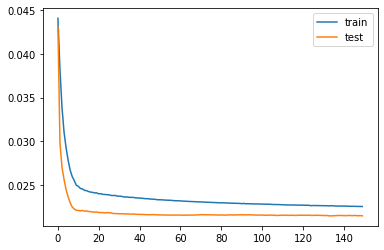

In [3]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [4]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.366


In [5]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 5.247


In [6]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.846


#**LAG=4**

In [3]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 4
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 2190 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
106/106 - 1s - loss: 0.0416 - val_loss: 0.0512
Epoch 2/150
106/106 - 0s - loss: 0.0338 - val_loss: 0.0441
Epoch 3/150
106/106 - 0s - loss: 0.0308 - val_loss: 0.0448
Epoch 4/150
106/106 - 0s - loss: 0.0287 - val_loss: 0.0472
Epoch 5/150
106/106 - 0s - loss: 0.0305 - val_loss: 0.0539
Epoch 6/150
106/106 - 0s - loss: 0.0331 - val_loss: 0.0260
Epoch 7/150
106/106 - 0s - loss: 0.0275 - val_loss: 0.0227
Epoch 8/150
106/106 - 0s - loss: 0.0258 - val_loss: 0.0226
Epoch 9/150
106/106 - 0s - loss: 0.0255 - val_loss: 0.0226
Epoch 10/150
106/106 - 0s - loss: 0.0248 - val_loss: 0.0221
Epoch 11/150
106/106 - 0s - loss: 0.0247 - val_loss: 0.0222
Epoch 12/150
106/106 - 0s - loss: 0.0243 - val_loss: 0.0219
Epoch 13/150
106/106 - 0s - loss: 0.0244 - val_loss: 0.0220
Epoch 14/150
106/106 - 0s - loss: 0.0241 - val_loss: 0.0219
Epoch 15/150
106/106 - 0s - loss: 0.0241 - val_loss: 0.0219
Epoch 16/150
106/106 - 0s - loss: 0.0239 - val_loss: 0.0218
Epoch 17/150
106/106 - 0s - loss: 0.0239 - val_lo

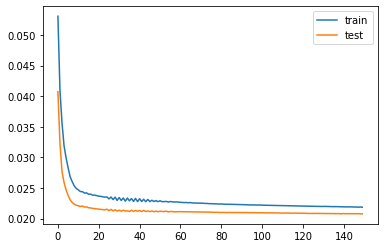

In [10]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [4]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.193


In [5]:
mean_squared_error(inv_y, inv_yhat)

67.12809

In [12]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 5.083


In [13]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.853


#**LAG=6**

In [16]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 6
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 2190 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
106/106 - 1s - loss: 0.0465 - val_loss: 0.0930
Epoch 2/150
106/106 - 1s - loss: 0.0441 - val_loss: 0.0362
Epoch 3/150
106/106 - 1s - loss: 0.0345 - val_loss: 0.0338
Epoch 4/150
106/106 - 1s - loss: 0.0314 - val_loss: 0.0329
Epoch 5/150
106/106 - 1s - loss: 0.0296 - val_loss: 0.0304
Epoch 6/150
106/106 - 1s - loss: 0.0280 - val_loss: 0.0285
Epoch 7/150
106/106 - 1s - loss: 0.0269 - val_loss: 0.0263
Epoch 8/150
106/106 - 1s - loss: 0.0260 - val_loss: 0.0239
Epoch 9/150
106/106 - 1s - loss: 0.0254 - val_loss: 0.0222
Epoch 10/150
106/106 - 1s - loss: 0.0246 - val_loss: 0.0226
Epoch 11/150
106/106 - 1s - loss: 0.0238 - val_loss: 0.0218
Epoch 12/150
106/106 - 1s - loss: 0.0245 - val_loss: 0.0226
Epoch 13/150
106/106 - 1s - loss: 0.0234 - val_loss: 0.0219
Epoch 14/150
106/106 - 1s - loss: 0.0246 - val_loss: 0.0218
Epoch 15/150
106/106 - 1s - loss: 0.0234 - val_loss: 0.0215
Epoch 16/150
106/106 - 1s - loss: 0.0240 - val_loss: 0.0222
Epoch 17/150
106/106 - 1s - loss: 0.0232 - val_lo

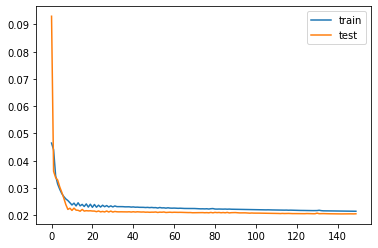

In [17]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [18]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.083


In [19]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 5.022


In [20]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.856


#**LAG=8**

In [25]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 8
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 2190 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
106/106 - 1s - loss: 0.0565 - val_loss: 0.0586
Epoch 2/150
106/106 - 1s - loss: 0.0423 - val_loss: 0.0441
Epoch 3/150
106/106 - 1s - loss: 0.0356 - val_loss: 0.0368
Epoch 4/150
106/106 - 1s - loss: 0.0322 - val_loss: 0.0326
Epoch 5/150
106/106 - 1s - loss: 0.0301 - val_loss: 0.0292
Epoch 6/150
106/106 - 1s - loss: 0.0286 - val_loss: 0.0254
Epoch 7/150
106/106 - 1s - loss: 0.0274 - val_loss: 0.0234
Epoch 8/150
106/106 - 1s - loss: 0.0255 - val_loss: 0.0230
Epoch 9/150
106/106 - 1s - loss: 0.0259 - val_loss: 0.0230
Epoch 10/150
106/106 - 1s - loss: 0.0243 - val_loss: 0.0230
Epoch 11/150
106/106 - 1s - loss: 0.0255 - val_loss: 0.0222
Epoch 12/150
106/106 - 1s - loss: 0.0240 - val_loss: 0.0219
Epoch 13/150
106/106 - 1s - loss: 0.0247 - val_loss: 0.0226
Epoch 14/150
106/106 - 1s - loss: 0.0233 - val_loss: 0.0222
Epoch 15/150
106/106 - 1s - loss: 0.0247 - val_loss: 0.0219
Epoch 16/150
106/106 - 1s - loss: 0.0234 - val_loss: 0.0215
Epoch 17/150
106/106 - 1s - loss: 0.0244 - val_lo

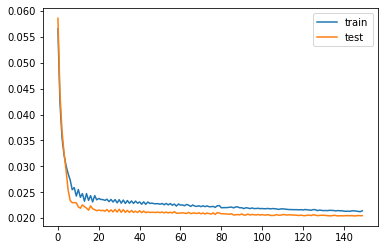

In [26]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.034


In [28]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 5.010


In [29]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.858


#**LAG=10**

In [32]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 10
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 2190 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
106/106 - 1s - loss: 0.0477 - val_loss: 0.0477
Epoch 2/150
106/106 - 1s - loss: 0.0337 - val_loss: 0.0301
Epoch 3/150
106/106 - 1s - loss: 0.0300 - val_loss: 0.0274
Epoch 4/150
106/106 - 1s - loss: 0.0279 - val_loss: 0.0258
Epoch 5/150
106/106 - 1s - loss: 0.0264 - val_loss: 0.0245
Epoch 6/150
106/106 - 1s - loss: 0.0253 - val_loss: 0.0240
Epoch 7/150
106/106 - 1s - loss: 0.0244 - val_loss: 0.0240
Epoch 8/150
106/106 - 1s - loss: 0.0237 - val_loss: 0.0237
Epoch 9/150
106/106 - 1s - loss: 0.0235 - val_loss: 0.0243
Epoch 10/150
106/106 - 1s - loss: 0.0234 - val_loss: 0.0261
Epoch 11/150
106/106 - 1s - loss: 0.0235 - val_loss: 0.0271
Epoch 12/150
106/106 - 1s - loss: 0.0236 - val_loss: 0.0310
Epoch 13/150
106/106 - 1s - loss: 0.0241 - val_loss: 0.0411
Epoch 14/150
106/106 - 1s - loss: 0.0271 - val_loss: 0.0470
Epoch 15/150
106/106 - 1s - loss: 0.0309 - val_loss: 0.0233
Epoch 16/150
106/106 - 1s - loss: 0.0253 - val_loss: 0.0222
Epoch 17/150
106/106 - 1s - loss: 0.0246 - val_lo

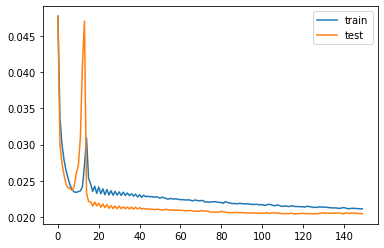

In [33]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.990


In [35]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 5.003


In [36]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.859


#**LAG=12**

In [41]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 12
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 2190 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
106/106 - 1s - loss: 0.0575 - val_loss: 0.0494
Epoch 2/150
106/106 - 1s - loss: 0.0414 - val_loss: 0.0374
Epoch 3/150
106/106 - 1s - loss: 0.0350 - val_loss: 0.0331
Epoch 4/150
106/106 - 1s - loss: 0.0319 - val_loss: 0.0309
Epoch 5/150
106/106 - 1s - loss: 0.0297 - val_loss: 0.0293
Epoch 6/150
106/106 - 1s - loss: 0.0283 - val_loss: 0.0271
Epoch 7/150
106/106 - 1s - loss: 0.0273 - val_loss: 0.0243
Epoch 8/150
106/106 - 1s - loss: 0.0264 - val_loss: 0.0229
Epoch 9/150
106/106 - 1s - loss: 0.0245 - val_loss: 0.0240
Epoch 10/150
106/106 - 1s - loss: 0.0257 - val_loss: 0.0221
Epoch 11/150
106/106 - 1s - loss: 0.0240 - val_loss: 0.0222
Epoch 12/150
106/106 - 1s - loss: 0.0250 - val_loss: 0.0219
Epoch 13/150
106/106 - 1s - loss: 0.0244 - val_loss: 0.0219
Epoch 14/150
106/106 - 1s - loss: 0.0235 - val_loss: 0.0216
Epoch 15/150
106/106 - 1s - loss: 0.0243 - val_loss: 0.0218
Epoch 16/150
106/106 - 1s - loss: 0.0237 - val_loss: 0.0216
Epoch 17/150
106/106 - 1s - loss: 0.0239 - val_lo

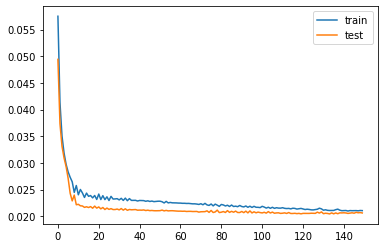

In [42]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [43]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.038


In [44]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 5.036


In [45]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.858


#**função com LAG correto**

In [3]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 2
n_features = 10

# frame as supervised learning
# reframed = series_to_supervised(scaled, n_hours, 1)
reframed = series_to_supervised(scaled, n_hours, 2)

# split into train and test sets
values = reframed.values
n_train_hours = 2190 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
106/106 - 1s - loss: 0.0542 - val_loss: 0.0411
Epoch 2/150
106/106 - 0s - loss: 0.0461 - val_loss: 0.0391
Epoch 3/150
106/106 - 0s - loss: 0.0435 - val_loss: 0.0379
Epoch 4/150
106/106 - 0s - loss: 0.0417 - val_loss: 0.0363
Epoch 5/150
106/106 - 1s - loss: 0.0402 - val_loss: 0.0351
Epoch 6/150
106/106 - 0s - loss: 0.0390 - val_loss: 0.0341
Epoch 7/150
106/106 - 1s - loss: 0.0382 - val_loss: 0.0335
Epoch 8/150
106/106 - 0s - loss: 0.0375 - val_loss: 0.0332
Epoch 9/150
106/106 - 0s - loss: 0.0372 - val_loss: 0.0329
Epoch 10/150
106/106 - 0s - loss: 0.0369 - val_loss: 0.0328
Epoch 11/150
106/106 - 1s - loss: 0.0366 - val_loss: 0.0327
Epoch 12/150
106/106 - 0s - loss: 0.0364 - val_loss: 0.0326
Epoch 13/150
106/106 - 0s - loss: 0.0363 - val_loss: 0.0327
Epoch 14/150
106/106 - 0s - loss: 0.0362 - val_loss: 0.0326
Epoch 15/150
106/106 - 0s - loss: 0.0361 - val_loss: 0.0325
Epoch 16/150
106/106 - 0s - loss: 0.0360 - val_loss: 0.0325
Epoch 17/150
106/106 - 0s - loss: 0.0359 - val_lo

In [4]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.646
